# Data visualization

This test allows us to corroborate the proper interpretation of the data of the spectral energy distributions coming from the active galaxies in the example.

## SED plots from example (AGNfitter v1.0)

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from astropy import units as u
import astropy.constants as const
import scipy
from mpl_toolkits.axes_grid.inset_locator import inset_axes
from matplotlib import gridspec
#from mpl_toolkits.axes_grid.inset_locator import inset_axes

/home/laura-pc/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: MatplotlibDeprecationWarning: 
The mpl_toolkits.axes_grid module was deprecated in Matplotlib 2.1 and will be removed two minor releases later. Use mpl_toolkits.axes_grid1 and mpl_toolkits.axisartist, which provide the same functionality instead.
  import sys


In [2]:
# Cosmology that we asume
from astropy.cosmology import FlatLambdaCDM
cosmo = FlatLambdaCDM(H0=70 * u.km / u.s / u.Mpc, Tcmb0=2.725 * u.K, Om0=0.266)

In [3]:
# Function to plot SED
def SED_plot(dataframe, galaxy_i, galaxy_f, cosmo, title, ylim_i, ylim_s, legend, SEDobserved, xaxis = 'f', wl_unit = 'micron', flux_unit = 'mJy'):
    """
    Function to plot the spectral energy distribution (SED). 
    
    Parameters:
    -----------
    dataframe : Pandas dataframe that contains all the information of the sample. Its format is: name, z, f, flux, err... 
    galaxy_i : initial galaxy of the sample
    galaxy_f : final galaxy of the sample
    cosmo: type of cosmology used to calculte the distance-luminosity relation
    title : Title of the plot
    ylim_i : lower y-axis limit
    ylim_s : upper y-axis limit
    legend : Boolean to decide if you want to see the name of the galaxies
    SEDobserved: Boolean to decide if you want to see the rest-frame SED or the reddened SED
    xaxis : String to choose the x-axis: frequency (f) or wavelegths (wl)
    wl_unit : Unit of wavelength: angstrom (A) or micron (micron)
    flux_unit : Unit of flux measurements: Jansky (Jy) or mJy
    
    Return:
    ----------
    fig : Plot of observed and synthetic SED
    f_rest : List of rest frame frequency
    flux : List of SED flux
    error : List of SED errors
    """      
    
    fig = plt.figure(figsize=(10, 6))
    plt.ylabel(r'$\nu L(\nu)$  $[erg \cdot s^{-1}]$', fontsize = 14) 
    
    #Name of the x-axis according to the choose: log(f) or log(wl)
    if xaxis == 'f':
        plt.xlabel(r'log($\nu$) ', fontsize = 14)   
    elif xaxis == 'wl':
        plt.xlabel(r'log($\lambda$) ', fontsize = 14) 
    #Units of the spectral flux density
    if flux_unit == 'mJy':
        flux_u = u.Jy*1e-3
    if flux_unit == 'Jy':
        flux_u = u.Jy
    #Units of wavelength    
    if wl_unit == 'A':
        wl_u = 1e-10
    if wl_unit == 'micron':
        wl_u = 1e-6
        
    f_rest_t = []
    flux_t = []
    error_t = []
    
    for i in range(galaxy_i, galaxy_f):
        z = dataframe.iloc[i, 1]                                                    # Redshift
        f_obs = (3*1e8)/(np.array(dataframe.iloc[i, 2::3])*wl_u)                    # Observed frequency [Hz]
        data_Jy = np.array(dataframe.iloc[i, 3::3])*flux_u                          # Spectral flux density [Jy]
        data = np.array([i.to(u.erg/u.s/(u.cm)**2 /u.Hz).value for i in data_Jy])   # Intensity [erg s⁻¹ cm⁻² Hz⁻¹]
        D_L = cosmo.luminosity_distance(z).to(u.cm).value                           # Relation distance-luminosity
        flux =  f_obs*data*4*np.pi*(D_L)**2                                         # Flux [erg s⁻¹]
        
        # Uncertainty [erg s⁻¹]
        error = f_obs*np.array([(i*flux_u).to(u.erg/u.s/(u.cm)**2 /u.Hz).value*4*np.pi*(D_L)**2 for i in dataframe.iloc[i, 4::3]])          
        name = dataframe.iloc[i, 0]                                             # Source name
        flux_t.append(flux)
        error_t.append(error)
        
        if SEDobserved == True:
            # OBSERVED SED  
            if xaxis == 'f':
                plt.loglog(f_obs, flux, marker = 'o', linestyle = '', label = str(name) + '  z = ' + str(round(z,4)))
                (_, caps, _) = plt.errorbar(f_obs,  flux, yerr=  error, xerr = 0,  fmt='o', markersize=0, capsize=3, color = 'black')
                for cap in caps:
                    cap.set_markeredgewidth(1)
                    
            elif xaxis == 'wl':
                plt.loglog((3*1e8)/f_obs, flux, marker = 'o', linestyle = '', label = str(name) + '  z = ' + str(round(z,4)))
                (_, caps, _) = plt.errorbar((3*1e8)/f_obs,  flux, yerr=  error, xerr = 0,  fmt='o', markersize=0, capsize=3, color = 'black')
                for cap in caps:
                    cap.set_markeredgewidth(1)
                    
        f_rest = f_obs*(1+z)                  # Rest frame frequency [Hz]   
        f_rest_t.append(f_rest)
        
        # REST FRAME SED
        if xaxis == 'f':
            plt.loglog(f_rest, flux, marker = 'o', linestyle = '', label = str(name) + '  Rest Frame ')
            (_, caps, _) = plt.errorbar(f_rest,  flux, yerr=  error, xerr = 0,  fmt='o', markersize=0, capsize=3, color = 'black')
            for cap in caps:
                cap.set_markeredgewidth(1)
                
        elif xaxis == 'wl':
            plt.loglog((3*1e8)/f_rest, flux, marker = 'o', linestyle = '', label = str(name) + '  Rest Frame ')
            (_, caps, _) = plt.errorbar((3*1e8)/f_rest,  flux, yerr=  error, xerr = 0,  fmt='o', markersize=0, capsize=3, color = 'black')
            for cap in caps:
                cap.set_markeredgewidth(1)
                
    plt.grid() 
    plt.title(title, fontsize = 15)
    if legend == True:
        plt.legend(fontsize = 9, shadow = True)
    plt.ylim(ylim_i, ylim_s)
    plt.xticks(size = 14)
    plt.yticks(size = 14)
    plt.close()
    return fig, f_rest_t, flux_t, error_t

In [4]:
# Data format
# Name, redshift, wavelength [x10**(-10)], Intensity [Jy], data uncertainty [Jy] and so on and so forth
SED = pd.read_csv("Examples/catalog_example.txt", delim_whitespace=True, decimal=".", skiprows = 0)

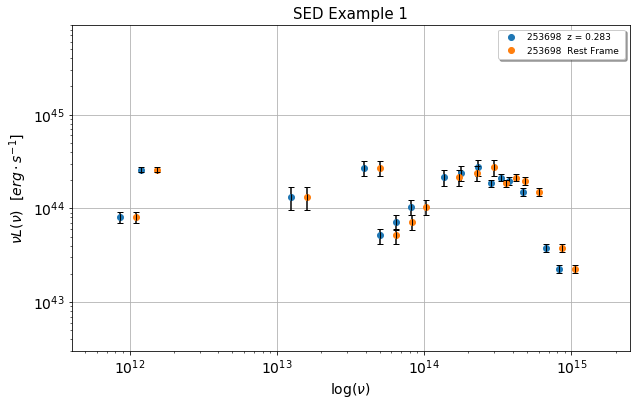

In [5]:
SED_plot(SED, 0, 1, cosmo, 'SED Example 1', 3*1e42, 9*1e45, True, True, 'f', 'A','Jy')[0]

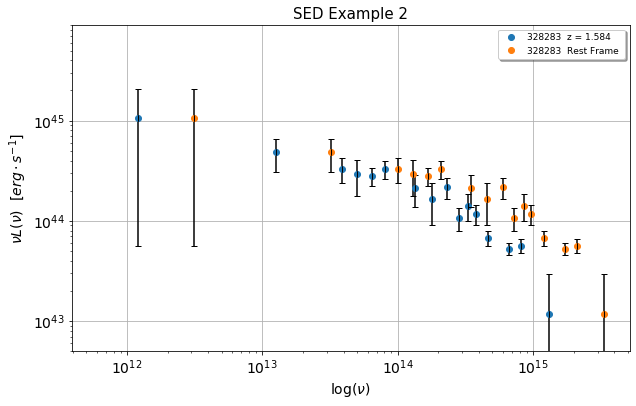

In [6]:
SED_plot(SED, 1, 2, cosmo, 'SED Example 2', 5*1e42, 9*1e45, True, True, 'f', 'A','Jy')[0]

## Plot of a telescope filter

Visualization of telescope filter:

In [7]:
# Subaru telescope transfer function (optical and IR)
Subaru_B = pd.read_csv("Filters/B_subaru.res", sep="  ", decimal=".", names = ['wl', 'I'], skiprows = 0, engine='python')

wl_SB = Subaru_B['wl']*10**(-1) # wavelength [nm]
I_SB = Subaru_B['I'] # Intensity

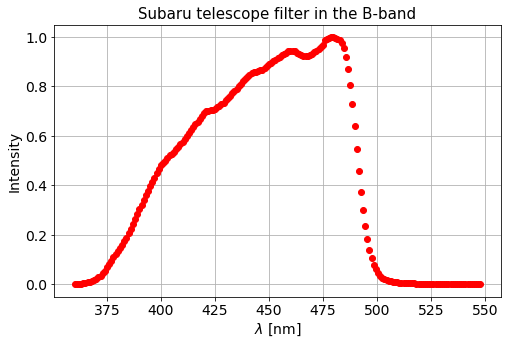

In [8]:
fig = plt.figure(figsize=(8, 5))
plt.ylabel(r'Intensity', fontsize = 14) 
plt.xlabel(r'$\lambda$ [nm]', fontsize = 14) 
plt.plot(wl_SB, I_SB ,color = 'r', marker = 'o', linestyle = '')
plt.grid() 
plt.title('Subaru telescope filter in the B-band', fontsize = 15)
plt.xticks(size = 14)
plt.yticks(size = 14)
plt.show()

Is valid the approximation of central wavelength in v_2.0?

In [9]:
# Data format
SPIRE250 = pd.read_csv("Filters/SPIRE_250mu.txt", delim_whitespace=True,  names = ['wl', 'I'], decimal=".", skiprows = 0)
SPIRE350 = pd.read_csv("Filters/SPIRE_350mu.txt", delim_whitespace=True,  names = ['wl', 'I'], decimal=".", skiprows = 0)
PACS100 = pd.read_csv("Filters/PACS_100mu.txt", delim_whitespace=True,  names = ['wl', 'I'], decimal=".", skiprows = 0)
MIPS70 = pd.read_csv("Filters/mips70.res", delim_whitespace=True,  names = ['wl', 'I'], decimal=".", skiprows = 9)

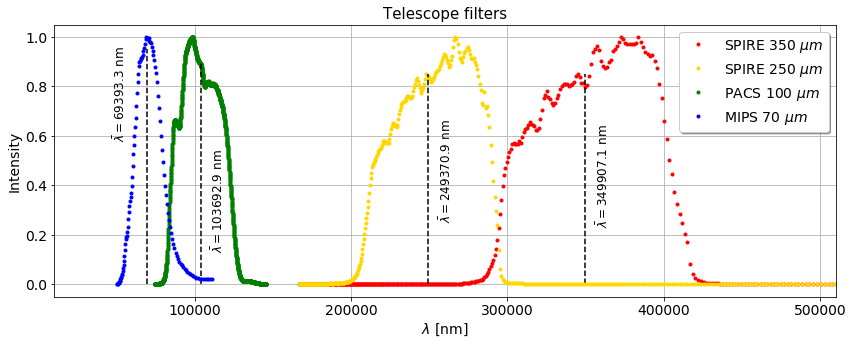

In [10]:
fig = plt.figure(figsize=(14, 5))
plt.ylabel(r'Intensity', fontsize = 14) 
plt.xlabel(r'$\lambda$ [nm]', fontsize = 14) 

# Transfer function
plt.plot(SPIRE350['wl']*1e-1, SPIRE350['I'],color = 'r', marker = '.', linestyle = '', label = r'SPIRE 350 $\mu m$')
plt.plot([3499071*1e-1,3499071*1e-1],[0, 0.85],color ='black',  linewidth=1.5, linestyle="--")  #central wavelengths
plt.annotate(r'$\bar{\lambda} = 349907.1$ nm', xy=(3499071*1e-1, 0.2), 
             xycoords='data',xytext=(+10, +10), textcoords='offset points', fontsize=12, rotation = 90)

plt.plot(SPIRE250['wl']*1e-1, SPIRE250['I'],color = 'gold', marker = '.', linestyle = '', label = r'SPIRE 250 $\mu m$')
plt.plot([2493709*1e-1,2493709*1e-1],[0, 0.85],color ='black',  linewidth=1.5, linestyle="--")
plt.annotate(r'$\bar{\lambda} = 249370.9$ nm', xy=(2493709*1e-1, 0.22), 
             xycoords='data',xytext=(+10, +10), textcoords='offset points', fontsize=12, rotation = 90)

plt.plot(PACS100['wl']*1e-1, PACS100['I'] ,color = 'g', marker = '.', linestyle = '', label = r'PACS 100 $\mu m$')
plt.plot([1036929*1e-1,1036929*1e-1],[0, 0.90],color ='black',  linewidth=1.5, linestyle="--")
plt.annotate(r'$\bar{\lambda} = 103692.9$ nm', xy=(1036929*1e-1, 0.1), 
             xycoords='data',xytext=(+10, +10), textcoords='offset points', fontsize=12,  rotation = 90)

plt.plot(MIPS70['wl']*1e-1, MIPS70['I'],color = 'b', marker = '.', linestyle = '', label = r'MIPS 70 $\mu m$')
plt.plot([693933*1e-1,693933*1e-1],[0, 0.95],color ='black',  linewidth=1.5, linestyle="--")
plt.annotate(r'$\bar{\lambda} = 69393.3$ nm', xy=(693933*1e-1, 0.55), 
             xycoords='data',xytext=(-35, +10), textcoords='offset points', fontsize=12,  rotation = 90)

plt.grid() 
plt.title(r'Telescope filters', fontsize = 15)
plt.legend(fontsize = 14, shadow = True)
plt.xlim(1e4,5.1*1e5)
plt.xticks(size = 14)
plt.yticks(size = 14)
plt.show()

## Plots of Brown data

In [11]:
# Data format
# Name, redshift, wavelength [x10**(-10)], Intensity [Jy], data uncertainty [Jy] and so on and so forth
SED_Brown_obsC = pd.read_csv("Brown_data/brown2018_obs_agnfitter.txt", delim_whitespace=True, decimal=".", skiprows = 0)
SED_Brown_obs = SED_Brown_obsC.iloc[:,1:]

The SEDs of the first 3 galaxies will be plotted.

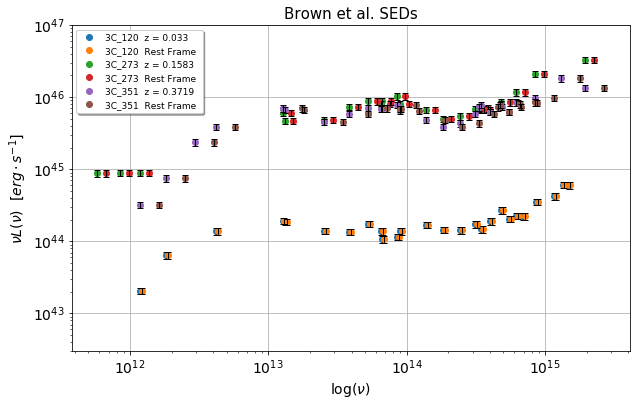

In [12]:
SED_plot(SED_Brown_obs, 1, 4, cosmo, 'Brown et al. SEDs', 3*1e42, 1e47, True, True)[0]

In [13]:
# Data format
# Name, redshift, wavelength [x10**(-10)], Intensity [Jy], data uncertainty [Jy] and so on and so forth
SED_Brown_synC = pd.read_csv("Brown_data/brown2018_syn_agnfitter-2.txt", delim_whitespace=True, decimal=".", skiprows = 0)
SED_Brown_syn = SED_Brown_synC.iloc[:,1:]

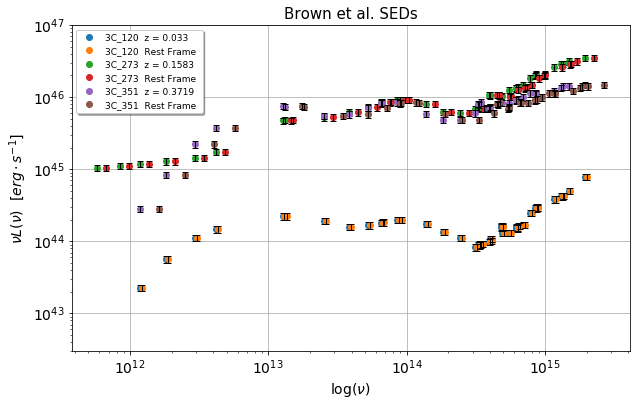

In [14]:
SED_plot(SED_Brown_syn, 1, 4, cosmo, 'Brown et al. SEDs', 3*1e42, 1e47, True, True)[0]

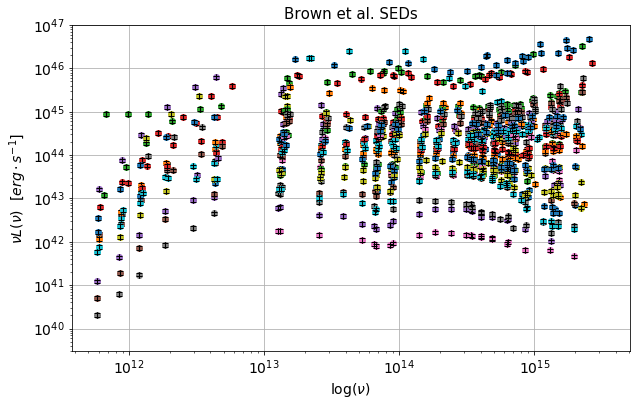

In [15]:
SED_plot(SED_Brown_obs, 0, 41, cosmo, 'Brown et al. SEDs', 3*1e39, 1e47, False, False)[0]

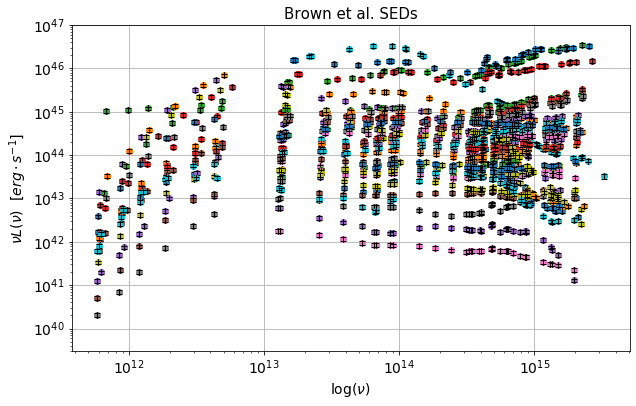

In [16]:
SED_plot(SED_Brown_syn, 0, 41, cosmo, 'Brown et al. SEDs', 3*1e39, 1e47, False, False)[0]

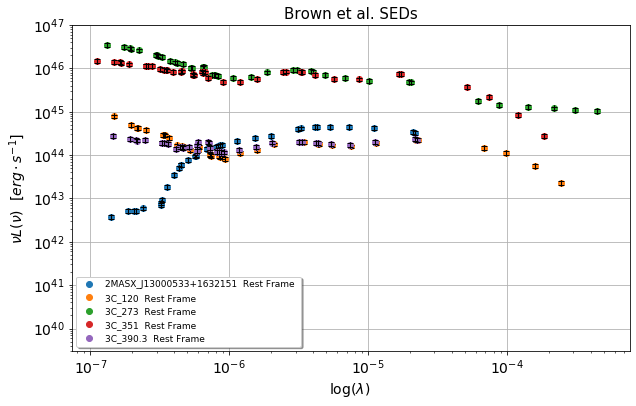

In [17]:
SED_plot(SED_Brown_syn, 0, 5, cosmo, 'Brown et al. SEDs', 3*1e39, 1e47, True, False, 'wl')[0]

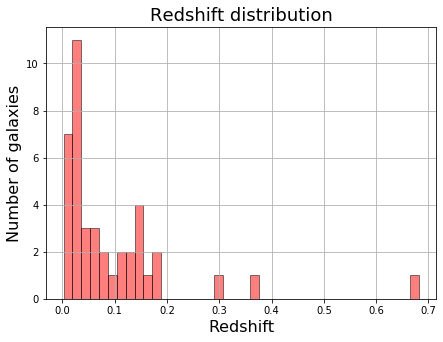

First range of Z: [0.0, 0.016972725]


In [18]:
z = SED_Brown_syn.iloc[:, 1]
bars = 40        #Number of intervals
fig=plt.figure(figsize=(7,5))
ax = z.plot.hist(edgecolor = 'black', color= 'r', alpha=0.5, bins= bars, zorder = 1) #Histogram of redshif on the sample
plt.title('Redshift distribution', fontsize = 18 )
plt.xlabel('Redshift', fontsize = 16)
plt.ylabel('Number of galaxies', fontsize = 16)
plt.grid()
plt.show()
print('First range of Z: ' + str([0.0, (z.max()-z.min())/bars]))

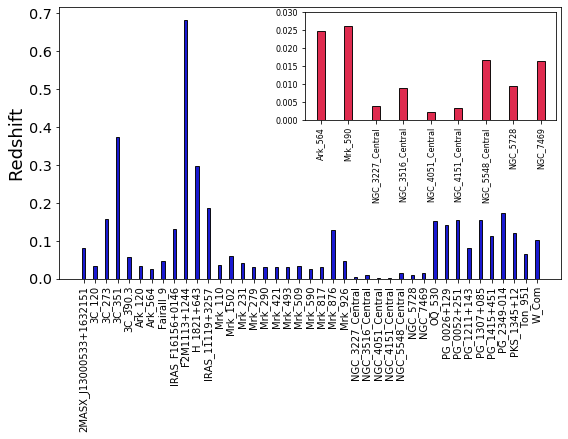

In [19]:
from mpl_toolkits.axes_grid.inset_locator import inset_axes

lowz = SED_Brown_syn[SED_Brown_syn['z'] <= 0.03]  # Zoom in galaxies with z < 0.03 (filter)

fig=plt.figure(figsize=(9,5))
ax = fig.add_subplot(111)
plt.ylabel('Redshift', linespacing=1, fontsize = 18)

# Redshift of all the sample of galaxies (41)
plt.bar(SED_Brown_syn.iloc[:, 0],SED_Brown_syn.iloc[:, 1],color='mediumblue',alpha=0.9, edgecolor = 'black', width=0.3)
plt.xticks(fontsize=10, rotation = 90)
plt.yticks(size = 'x-large')
inset_ax = inset_axes(ax, 
                    width="50%", # width = 30% of parent_bbox
                    height=1.5, # height : 1 inch
                    loc=1)
# Redshift of galaxies with z < 0.03
plt.bar(lowz.iloc[:, 0],lowz.iloc[:, 1],color='crimson',alpha=0.9, edgecolor = 'black', width=0.3)
plt.xticks(lowz.iloc[:, 0], fontsize=8, rotation = 90)
plt.yticks(np.linspace(0,0.03, 7),fontsize=8)
plt.show()

In [20]:
def SED_ObsvsSyn(galaxy_i, galaxy_f, obs, syn, ylim_i, ylim_s):
    """
    Function to plot the observed and synthetic SEDs together. 
    
    Parameters:
    -----------
    galaxy_i : initial galaxy of the sample
    galaxy_f : final galaxy of the sample
    obs : Output of SED_plot function with observed data
    syn : Output of SED_plot function with synthetic
    ylim_i : lower y-axis limit
    ylim_s : upper y-axis limit
    
    Return:
    ----------
    fig : Plot of observed and synthetic SED
    """   
    galaxy = SED_Brown_obs.iloc[:, 0]
    fig = plt.figure(figsize=(10, 6))
    plt.ylabel(r'$\nu L(\nu)$  $[erg \cdot s^{-1}]$', fontsize = 14) 
    plt.xlabel(r'log($\nu$) ', fontsize = 14) 

    for i in range(galaxy_i, galaxy_f):
        plt.loglog(obs[1][i], obs[2][i], marker = 'd', linestyle = '', label = str(galaxy[i]) + '  Obs', zorder= 9)
        plt.errorbar(obs[1][i], obs[2][i], yerr=  obs[3][i], xerr = 0,  fmt='o', markersize=0, capsize=3, color = 'black', zorder = 10)
            
        plt.loglog(syn[1][i], syn[2][i], marker = 'o', linestyle = '', color = 'r', label = str(galaxy[i]) + '  Syn')
        plt.errorbar(syn[1][i], syn[2][i], yerr=  syn[3][i], xerr = 0,  fmt='o', markersize=0, capsize=3, color = 'black')    
        
    plt.grid() 
    plt.title('Observed vs synthetic SEDs', fontsize = 15)
    plt.legend(fontsize = 9, shadow = True)
    plt.ylim(ylim_i, ylim_s)
    plt.xticks(size = 14)
    plt.yticks(size = 14)
    plt.close()
    #plt.show()
    return fig

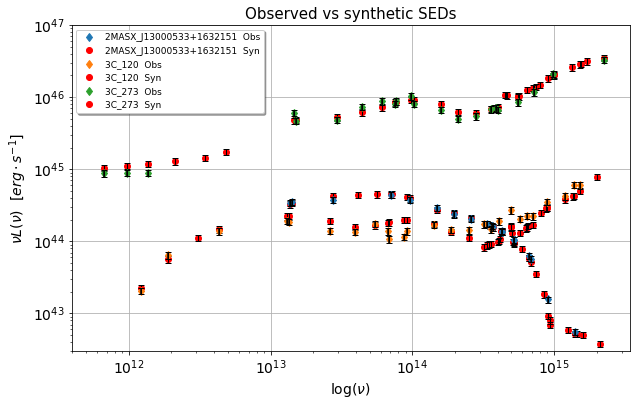

In [21]:
obs = SED_plot(SED_Brown_obs, 0, 41, cosmo, 'Brown et al. SEDs', 3*1e39, 1e47, False, False)
syn = SED_plot(SED_Brown_syn, 0, 41, cosmo, 'Brown et al. SEDs', 3*1e39, 1e47, False, False)
SED_ObsvsSyn(0, 3, obs, syn, 3*1e42, 1e47)

In [22]:
def Photo_bands(galaxy_i, galaxy_f, cosmo, ylim_i, ylim_s, legendSED = False):
    """
    Function to study corrections on photometric data. 
    
    Parameters:
    -----------
    galaxy_i : initial galaxy of the sample
    galaxy_f : final galaxy of the sample
    cosmo: type of cosmology used to calculte the distance-luminosity relation
    ylim_i : lower y-axis limit
    ylim_s : upper y-axis limit
    legendSED : Boolean to decide if you want to see the name of the galaxies
    
    Return:
    ----------
    fig : Plot of SED of the corrected data
    fig_z : Plot of the correlation between number of corrected data and redshift
    fig_obs : Histogram of valid observed data
    fig_syn : Histogram of valid synthetic data
    fig_nbr : Histogram of corrected data
    """    
    Nbands_obs = []
    Nbands_syn = []
    Nbands_recover = []

    # SED plot of corrected data
    fig = plt.figure(figsize=(12, 6))
    plt.ylabel(r'$\nu L(\nu)$  $[erg \cdot s^{-1}]$', fontsize = 14) 
    plt.xlabel(r'Telescopes', fontsize = 14) 
    plt.title('Brown et al. corrected data', fontsize = 15)
    
    for i in range(galaxy_i, galaxy_f):
        count_obs = 0
        count_syn = 0
        name = SED_Brown_obs.iloc[i, 0] 
        z = SED_Brown_obs.iloc[i, 1] 
        D_L = cosmo.luminosity_distance(z).to(u.cm).value
        f_obs = []
        flux = []
        error = []
        
        for j in range(1,43):
            if SED_Brown_obs.iloc[i, j*3] > 0:  #Valid data counts, namely when data ≠ -999.9 or simply positive
                count_obs += 1
                
            if SED_Brown_syn.iloc[i, j*3] > 0: 
                count_syn += 1
            # To count data that, when observed, were invalid but corrected (synthetic) 
            if SED_Brown_obs.iloc[i, j*3] < 0 and SED_Brown_syn.iloc[i, j*3] > 0:
                intensity = (SED_Brown_syn.iloc[i, j*3]*u.Jy*1e-3).to(u.erg/u.s/(u.cm)**2 /u.Hz).value   # Intensity [erg s⁻¹ cm⁻² Hz⁻¹]
                freq = (3*1e8)/(np.array(SED_Brown_syn.iloc[i, j*3-1])*1e-6)                                  # Frequency [Hz]
                f_obs.append(freq)
                flux.append(freq*intensity*4*np.pi*(D_L)**2)                                                # Flux [erg s⁻¹]
                # Uncertainty [erg s⁻¹]
                error.append(freq*(SED_Brown_syn.iloc[i, j*3 +1]*u.Jy*1e-3).to(u.erg/u.s/(u.cm)**2 /u.Hz).value*4*np.pi*(D_L)**2)  
                
        Nbands_obs.append(count_obs)     
        Nbands_syn.append(count_syn)
        Nbands_recover.append(len(flux))
   
        plt.loglog(f_obs, flux, marker = 'o', linestyle = '',label = str(name) + 'z = ' + str(z))
        (_, caps, _) = plt.errorbar(f_obs,  flux, yerr=  error, xerr = 0,  fmt='o', markersize=0, capsize=3, color = 'black')
        for cap in caps:
            cap.set_markeredgewidth(1)           
        
    f = (3*1e8)/(np.array(SED_Brown_syn.iloc[1, 2::3])*1e-6)
    if legendSED == True:
        plt.legend(fontsize = 9, shadow = True)
    plt.ylim(ylim_i, ylim_s)
    plt.xlim(4*10e10, 3.5*10e14)
    #telescopes = [i for i in list(SED_Brown_syn.columns)[3::3]]
    telescopes0 = [i[:-3] for i in list(SED_Brown_syn.columns)[2::6]]
    telescopes1 = [i[:-3] + '         ' for i in list(SED_Brown_syn.columns)[5::6]]
    telescopes = [item for sublist in zip(telescopes0,telescopes1) for item in sublist]
    plt.xticks(list(f), telescopes, size= 10, rotation = 90)
    plt.yticks(size =14)
    plt.grid(True, which = 'major', axis = 'y')
    ax1 = plt.gca()
    ax2 = ax1.twiny()
    ax2.loglog()
    ax2.set_xlim(4*10e10, 3.5*10e14)
    ax2.tick_params(axis="x", labelsize=14)
    ax2.set_xlabel(r'log($\nu$)', fontsize = 14)
    ax2.grid(True, which = 'major')

    #Plot of corrected bands vs redshift
    fig_z = plt.figure(figsize = (8,5))
    plt.title('Number of corrected bands vs Z', fontsize = 15)
    plt.ylabel(r'# Corrected data', fontsize = 14) 
    plt.xlabel(r'Z', fontsize = 14) 
    plt.plot(SED_Brown_obs.iloc[galaxy_i: galaxy_f, 1], Nbands_recover, marker = 'o', linestyle = '')
    plt.grid()
    plt.yticks(size = 14)
    plt.xticks(size = 14)
    
    #Plots of photometric bands observed for each galaxy
    fig_obs=plt.figure(figsize=(10,5))
    plt.ylabel('Photometric bands observed', linespacing=1, fontsize = 14)
    plt.bar(SED_Brown_obs.iloc[galaxy_i: galaxy_f, 0],Nbands_obs,color='orange',alpha=0.9, edgecolor = 'black', width=0.3)
    plt.xticks(fontsize=10, rotation = 90)
    plt.yticks(size = 'x-large')

    #Plots of photometric bands with corrections for each galaxy
    fig_syn=plt.figure(figsize=(10,5))
    plt.ylabel('Photometric bands with corrections', linespacing=1, fontsize = 14)
    plt.bar(SED_Brown_syn.iloc[galaxy_i: galaxy_f, 0], Nbands_syn,color='purple',alpha=0.9, edgecolor = 'black', width=0.3)
    plt.xticks(fontsize=10, rotation = 90)
    plt.yticks(size = 'x-large')
    
    #Plots of photometric bands corrected for each galaxy
    fig_nbr=plt.figure(figsize=(10,5))
    plt.ylabel('Photometric bands corrected', linespacing=1, fontsize = 14)
    plt.bar(SED_Brown_syn.iloc[galaxy_i: galaxy_f, 0], Nbands_recover,color='green',alpha=0.9, edgecolor = 'black', width=0.3)
    plt.xticks(fontsize=10, rotation = 90)
    plt.yticks(size = 'x-large')
    
    return fig, fig_z, fig_obs, fig_syn, fig_nbr

(<Figure size 864x432 with 2 Axes>,
 <Figure size 576x360 with 1 Axes>,
 <Figure size 720x360 with 1 Axes>,
 <Figure size 720x360 with 1 Axes>,
 <Figure size 720x360 with 1 Axes>)

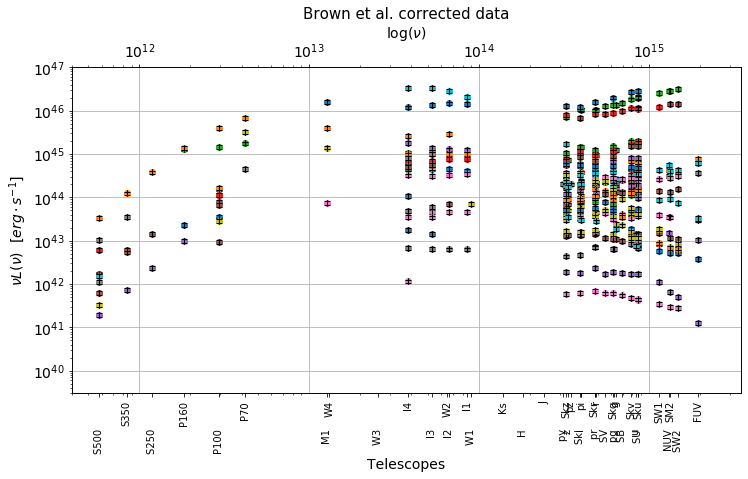

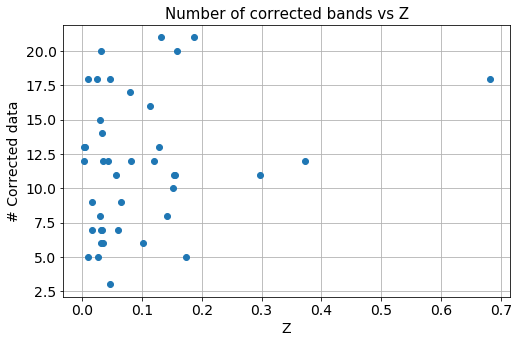

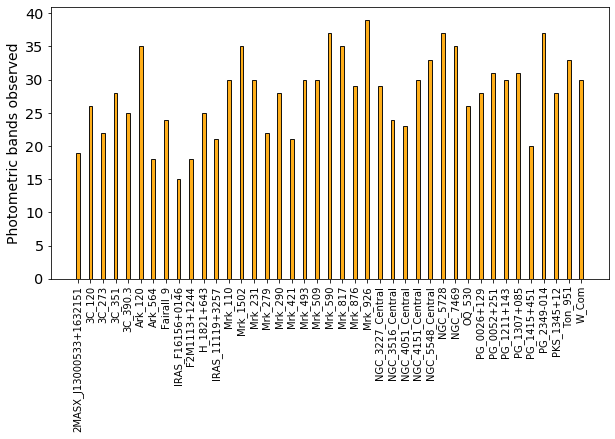

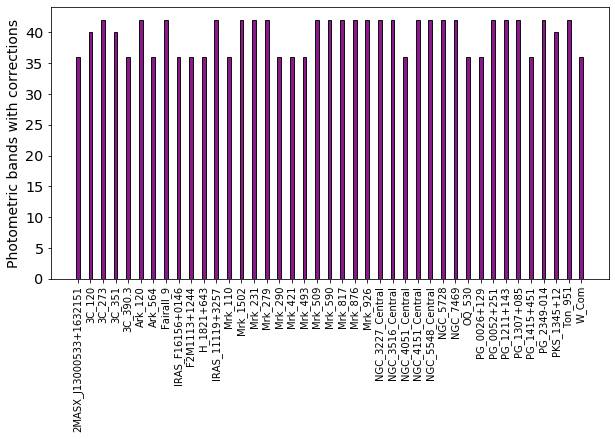

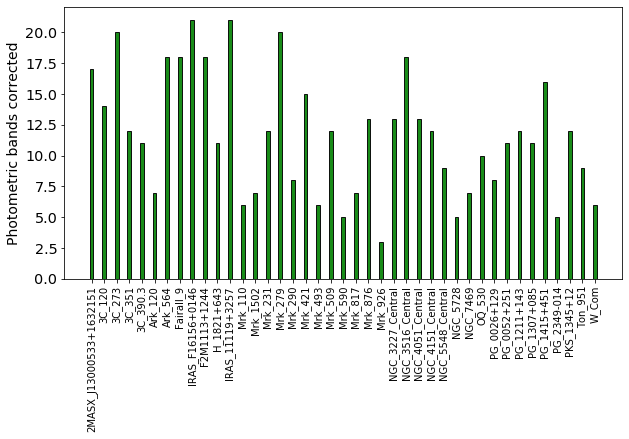

In [23]:
Photo_bands(0, 41, cosmo, 3*1e39, 1e47)

## Galaxies with x-ray and radio data

In [24]:
SED_B = pd.read_csv("Brown_data/hlsp_agnsedatlas_multi_photometry_all_multi_v1_syn-cat.csv", sep = ',', decimal=".", skiprows = 0)
len(SED_B.columns)    #Same photometric bands

45

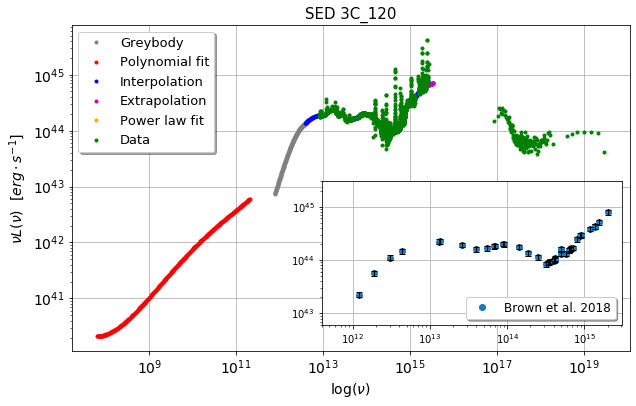

In [25]:
SED_B = pd.read_csv("Brown_data/Complete_data/hlsp_agnsedatlas_multi_multi_3c120_multi_v1_spec-rest.txt", delim_whitespace=True, decimal=".", names= ['rf_wl', 'L_nu', 'f_lam', 'scale', 'source'], skiprows = 11)

def filter_data(SED_B):  #Filter data according to the source
    grey = SED_B[SED_B['source'] == 'Greybody']
    poly = SED_B[SED_B['source'] == 'Polynomial_fit']
    interp = SED_B[SED_B['source'] == 'Interpolation']
    extra = SED_B[SED_B['source'] == 'Extrapolation']
    power = SED_B[SED_B['source'] == 'Power_law_fit']
    data = SED_B[(SED_B['source'] != 'Power_law_fit') & (SED_B['source'] != 'Extrapolation') & (SED_B['source'] != 'Interpolation') & (SED_B['source'] != 'Polynomial_fit') & (SED_B['source'] != 'Greybody')]
    return grey, poly, interp, extra, power, data
    
def freq_flux(dataframe):
    # To calculte the frequency and flux from the wavelength in microns and the spectral density (second column)
    f_rest = 3*1e8/(np.array(dataframe.iloc[:,0])*1e-6)
    flux = (np.array(dataframe.iloc[:,1])*f_rest*u.watt).to(u.erg/u.s).value
    return f_rest, flux

def colors_source(filters):
    # To plot data with different colors according with the source
    a = plt.loglog(freq_flux(filters[0])[0], freq_flux(filters[0])[1],color = 'grey', marker = '.', linestyle = '', label = 'Greybody')
    b = plt.loglog(freq_flux(filters[1])[0], freq_flux(filters[1])[1] ,color = 'red', marker = '.', linestyle = '', label = 'Polynomial fit')
    c = plt.loglog(freq_flux(filters[2])[0], freq_flux(filters[2])[1] ,color = 'blue', marker = '.', linestyle = '', label = 'Interpolation')
    d = plt.loglog(freq_flux(filters[3])[0], freq_flux(filters[3])[1] ,color = 'm', marker = '.', linestyle = '', label = 'Extrapolation')
    e = plt.loglog(freq_flux(filters[4])[0], freq_flux(filters[4])[1] ,color = 'orange', marker = '.', linestyle = '', label = 'Power law fit')
    f = plt.loglog(freq_flux(filters[5])[0], freq_flux(filters[5])[1] ,color = 'green', marker = '.', linestyle = '', label = 'Data')
    return a,b,c,d,e,f
    
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111)
plt.ylabel(r'$\nu L(\nu)$  $[erg \cdot s^{-1}]$', fontsize = 14) 
plt.xlabel(r'log($\nu$) ', fontsize = 14) 
colors_source(filter_data(SED_B))
plt.grid() 
plt.title('SED 3C_120', fontsize = 15)
plt.legend(fontsize = 13, shadow = True, loc=2)
plt.xticks(size = 14)
plt.yticks(size = 14)
in_ax = inset_axes(ax, 
                    width="50%", # width = 30% of parent_bbox
                    height=2.0, # height : 1 inch
                    loc=4, bbox_to_anchor=(45, 75, 600, 4))

# Plot of Brown et al. 2018 data to compare
photo_data = SED_plot(SED_Brown_syn, 1, 2, cosmo, 'Brown et al. SEDs', 6*1e42, 3*1e45, True, False)
plt.loglog(photo_data[1][0], photo_data[2][0], marker = 'o', linestyle = '', label = 'Brown et al. 2018')
plt.errorbar(photo_data[1][0],  photo_data[2][0], yerr=  photo_data[3][0], xerr = 0,  fmt='.', markersize=0, capsize=3, color = 'black')
plt.ylim(6*1e42, 3*1e45)
plt.legend(fontsize = 12, shadow = True, loc = 4)
plt.grid(True)
plt.show()

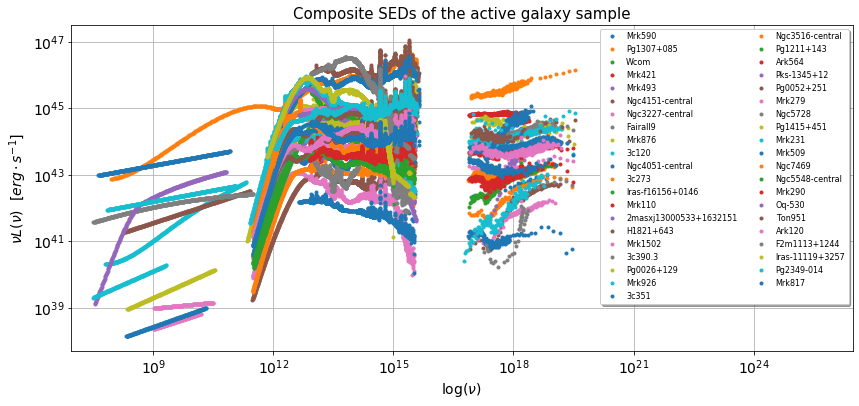

In [26]:
import os
column_names = ["Name", 'Data', 'Radio', 'X-ray']  #To create the columns of the dataframe
SED = pd.DataFrame(columns = column_names)

fig = plt.figure(figsize=(14, 6))
plt.ylabel(r'$\nu L(\nu)$  $[erg \cdot s^{-1}]$', fontsize = 14) 
plt.xlabel(r'log($\nu$) ', fontsize = 14) 

for i in os.listdir("Brown_data/Complete_data"):
    #To read the data of each galaxy in the folder
    data = pd.read_csv("Brown_data/Complete_data/" + i, delim_whitespace=True, decimal=".", names= ['rf_wl', 'L_nu', 'f_lam', 'scale', 'source'], skiprows = 11)
    New_row = {'Name': i[29:-23].capitalize(), 'Data': len(data.iloc[:,0])}  # Dictionary with the name and number of data of each galaxy
    
    freq = 3*1e8/(np.array(data.iloc[:,0])*1e-6)
    flux = (np.array(data.iloc[:,1])*freq*u.watt).to(u.erg/u.s).value
    New_row['freq'] = freq   # We added the frequency and flux list 
    New_row['flux'] =  flux
    
    plt.loglog(freq, flux, marker = '.', linestyle = '', label = i[29:-23].capitalize())
    
    # We tested if data are in radio or x-ray range and save this information as a boolean (1 or 0)
    if any(t < 5*1e10 for t in freq):
        New_row['Radio']= 1
    else:
        New_row['Radio']= 0
        
    if any(t > 3*1e16 for t in freq):
        New_row['X-ray']= 1
    else:
        New_row['X-ray']= 0
        
    SED = SED.append(New_row, ignore_index = True)     # To add this dictionary as a new row of the dataframe
    
plt.grid() 
plt.title('Composite SEDs of the active galaxy sample', fontsize = 15)
plt.legend(fontsize = 8, shadow = True, ncol = 2)
plt.xlim(9*1e6, 3*1e26)
plt.xticks(size = 14)
plt.yticks(size = 14)
plt.show()

In [27]:
n_rad = SED[SED['Radio'] == 1]  #Filter galaxies with radio data
n_xr = SED[SED['X-ray'] == 1]   #Filter galaxies with x-ray data
n_both = SED[(SED['Radio'] == 1) & (SED['X-ray'] == 1)]   #Filter galaxies with radio and x-ray data

print('Galaxies with radio data available: ' + str(len(n_rad)))
print('Galaxies with X-ray data available: ' + str(len(n_xr)))
print('Galaxies with radio and X-ray data available: ' + str(len(n_both)) + '. They are: ')
print(np.array(n_both.iloc[:,0]))

Galaxies with radio data available: 12
Galaxies with X-ray data available: 27
Galaxies with radio and X-ray data available: 10. They are: 
['Mrk876' '3c120' '3c273' '3c390.3' '3c351' 'Pks-1345+12' 'Mrk231'
 'Ark120' 'Pg2349-014' 'Mrk817']


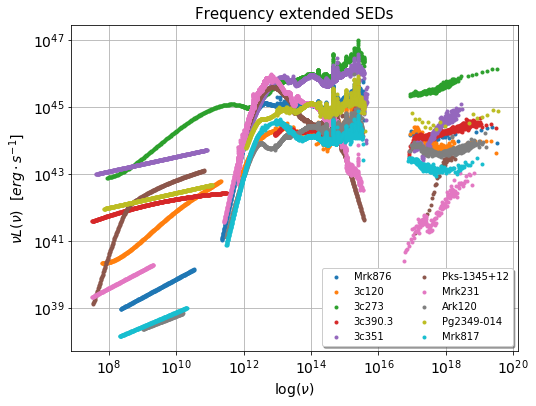

In [28]:
# To plot the SED of the subsample of galaxies
fig = plt.figure(figsize=(8, 6))
plt.ylabel(r'$\nu L(\nu)$  $[erg \cdot s^{-1}]$', fontsize = 14) 
plt.xlabel(r'log($\nu$) ', fontsize = 14) 

for i in range(len(n_both)):
    plt.loglog(n_both['freq'].iloc[i], n_both['flux'].iloc[i], marker = '.', linestyle = '', label = n_both['Name'].iloc[i])

plt.grid() 
plt.title('Frequency extended SEDs', fontsize = 15)
plt.legend(fontsize = 10, shadow = True, ncol = 2)
#plt.xlim(9*1e6, 3*1e26)
plt.xticks(size = 14)
plt.yticks(size = 14)
plt.show()

In [29]:
#BEname = [r'^'+i[0] +'.*'+ i[-2:] +'$' for i in n_both.iloc[:,0]] #Strings that begins and ends with the same substrings
#SED_Brown_obs[SED_Brown_obs['Name'].str.contains('|'.join(BEname))]

BEname = []    #Strings that begins and ends with the same substring
for i in n_both.iloc[:,0]:
    if '+' in i:
        BEname.append(r'^'+i[0] +'.*'+ i[-2:] +'$')
    else: 
        BEname.append(r'^'+i[0] +'.*'+ i[-3:] +'$')

z_sub = []    #Redshift of the subsample of galaxies
for i in BEname:
    # The idea is to save the corresponding z to each galaxy as a column of the dataframe
    redshift = SED_Brown_obs[SED_Brown_obs['Name'].str.contains(i)]['z'].values.item()
    z_sub.append(redshift)
n_both.insert(1, 'z', z_sub)

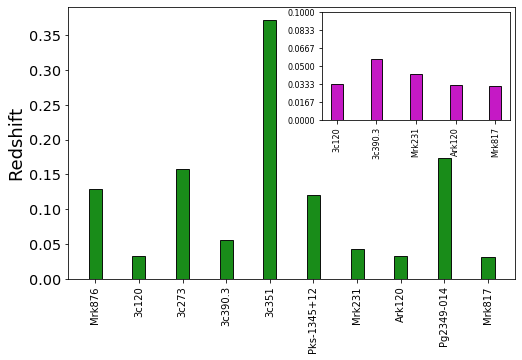

In [30]:
lowz_s = n_both[n_both['z'] <= 0.1]  # Zoom in galaxies with z < 0.1 (filter)

fig=plt.figure(figsize=(8,5))
ax = fig.add_subplot(111)
plt.ylabel('Redshift', linespacing=1, fontsize = 18)

# Redshift of all the sample of galaxies (10)
plt.bar(n_both.iloc[:, 0],n_both.iloc[:, 1],color='green',alpha=0.9, edgecolor = 'black', width=0.3)
plt.xticks(fontsize=10, rotation = 90)
plt.yticks(size = 'x-large')
inset_ax = inset_axes(ax, 
                    width="42%", # width = 30% of parent_bbox
                    height=1.5, # height : 1 inch
                    loc=1)
# Redshift of galaxies with z < 0.1
plt.bar(lowz_s.iloc[:, 0],lowz_s.iloc[:, 1],color='m',alpha=0.9, edgecolor = 'black', width=0.3)
plt.xticks(lowz_s.iloc[:, 0], fontsize=8, rotation = 90)
plt.yticks(np.linspace(0,0.1, 7),fontsize=8)
plt.show()

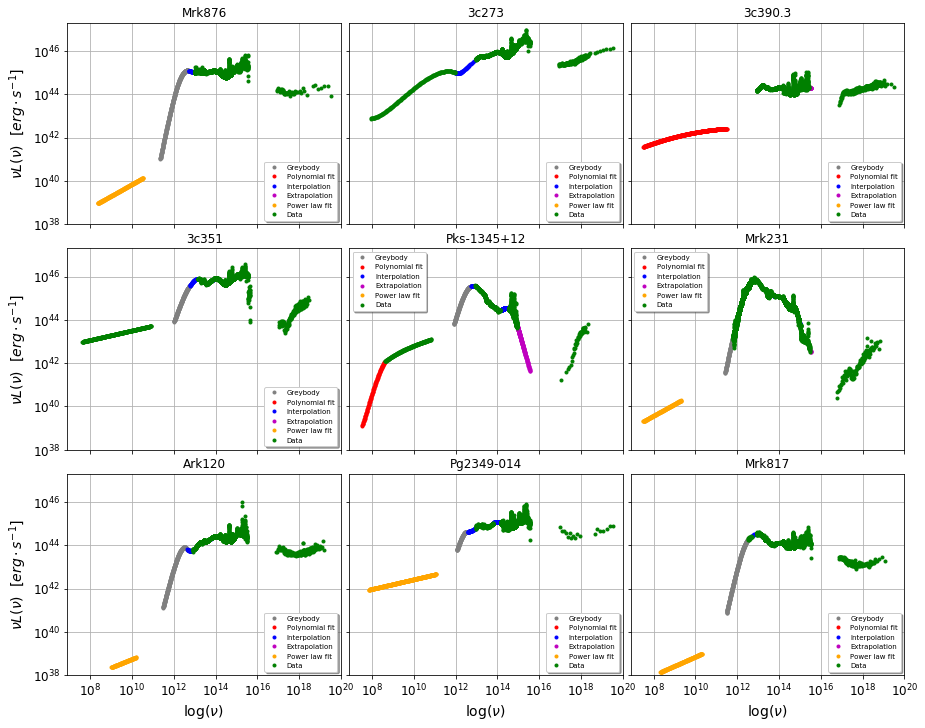

In [31]:
# Plot of the 9 SEDs with the colors code according to the source to study variability
plt.figure(figsize = (15,12))
fig = gridspec.GridSpec(3, 3)
fig.update(wspace=0.03, hspace=0.12)
j = 0
for i in os.listdir("Brown_data/Complete_data"):
    if i[29:-23] in [i.lower() for i in n_both['Name']] and i[29:-23] != '3c120':
        SED = pd.read_csv("Brown_data/Complete_data/" + i, delim_whitespace=True, decimal=".", names= ['rf_wl', 'L_nu', 'f_lam', 'scale', 'source'], skiprows = 11)
        x = plt.subplot(fig[j])
        colors_source(filter_data(SED))
        x.set_title(i[29:-23].capitalize())
        plt.xlim(8*1e6, 1e20)
        plt.ylim(1e38, 2*1e47)
        x.grid(True)
        if j == 0 or j== 3:
            plt.ylabel(r'$\nu L(\nu)$  $[erg \cdot s^{-1}]$', fontsize = 14)
            x.set_xticklabels([])
            plt.yticks(size = 12)
        elif j == 6:  
            plt.xlabel(r'log($\nu$) ', fontsize = 14) 
            plt.ylabel(r'$\nu L(\nu)$  $[erg \cdot s^{-1}]$', fontsize = 14)
            plt.xticks(size = 12)
            plt.yticks(size = 12)
        elif j == 7 or j == 8:
            plt.xlabel(r'log($\nu$) ', fontsize = 14) 
            plt.xticks(size = 12)
            x.set_yticklabels([])  
        else:
            x.set_xticklabels([])
            x.set_yticklabels([]) 
        if j == 4 or j == 5:
            plt.legend(fontsize = 7, shadow = True, ncol = 1, loc = 2)
        else: 
            plt.legend(fontsize = 7, shadow = True, ncol = 1, loc = 4)
        
        j += 1
        

## Dictionaries handling

To understand and redefine the line 142 in RUN_AGNfitter_multi.py

In [32]:
# Dictionary similar to FILTERS_settings() in SETTINGS_AGNfitter.py
filters_settings = dict(z = np.array([0.894, 2.43, 0.731]), path= 'models/FILTERS/', SPIRE500 = [True, 29], Ks_VISTA = [False, 3], r_SDSS= [True, 4], add_filters = False)
filters_settings.keys()

dict_keys(['z', 'path', 'SPIRE500', 'Ks_VISTA', 'r_SDSS', 'add_filters'])

In [33]:
# To choose the type non-booleans values with first position == True --> Filters
[filters_settings[i] for i in filters_settings.keys() if type(filters_settings[i]) != bool and filters_settings[i][0] == True]

[[True, 29], [True, 4]]

In [34]:
# To count and choose the type list values with first position == True --> Filters
print(len([filters_settings[i] for i in filters_settings.keys() if type(filters_settings[i]) == list and filters_settings[i][0] == True]))

# To corroborate that these are filters
print([i for i in filters_settings.keys() if type(filters_settings[i]) == list and filters_settings[i][0] == True])

2
['SPIRE500', 'r_SDSS']


## SED plots from example (AGNfitter v2.0)

In [35]:
# Data format
# Name, redshift, Intensity [mJy], data uncertainty [mJy] and so on and so forth
SED2 = pd.read_csv("Examples/catalog_example2.txt", delim_whitespace=True, decimal=".", skiprows = 0)
l_c = [1516, 2304, 3591, 4723, 6213, 7523, 8855, 4866, 6215, 7545, 8679, 9633, 8798, 10214, 12535, 16453, 21540, 10319, 12510, 16377, 22083, 33792, 46293, 123337, 222532, 1036929, 1697692, 2493709, 3499071, 5041086]
name = [i[:-5] for i in SED2.columns[2::2]]

#We added the wavelength of each telescope in the respective columns
# The final format is Name, redshift, wavelength [x10**(-10)], Intensity [Jy], data uncertainty [Jy] and so on and so forth
for i in range(len(l_c)):
    SED2.insert(loc= 2 + i*3, column = name[i] + '_wl', value = np.ones(len(SED2.iloc[:,0]))*l_c[i])

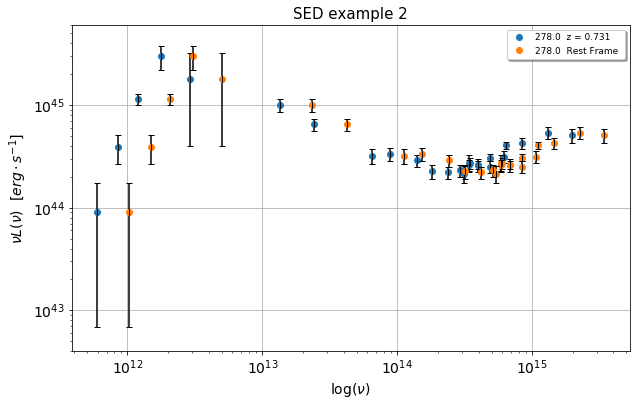

In [36]:
SED_plot(SED2, 2, 3, cosmo, 'SED example 2', 4*1e42, 6*1e45, True, True, 'f', 'A', 'mJy')[0]

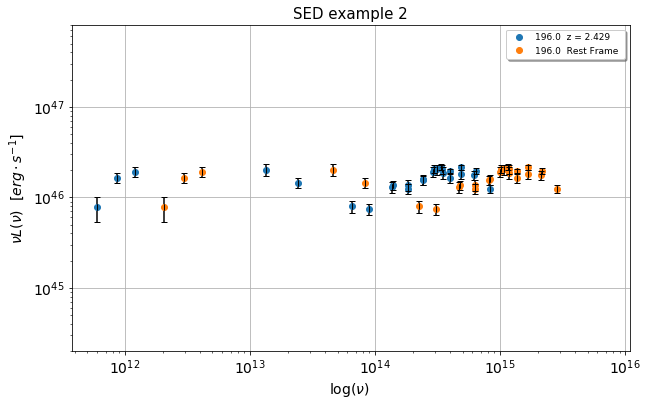

In [37]:
SED_plot(SED2, 1, 2, cosmo, 'SED example 2', 2*1e44, 8*1e47, True, True, 'f', 'A', 'mJy')[0]

### Output

Now we present the plot of the parameter values for different percentiles: 2.5, 16, 50, 84 and 97.5. The parameters inferred from the SED fit are: metallicity, exponential decay time, galaxy age, galaxy reddening, dust fraction in starburst, PAH fraction in starburst, column density, BBB reddening, normalisation parameters, absolute magnitude of the galaxy, star formation rate (optical), luminosity of: IR component, BBB, BBB reddened, galaxy, torus and starburst; star formation rate (IR) and likehood (?).

In [38]:
par278 = pd.read_csv("Examples/parameter_outvalues_278.0.txt", delim_whitespace=True, decimal=".", skiprows = 3)

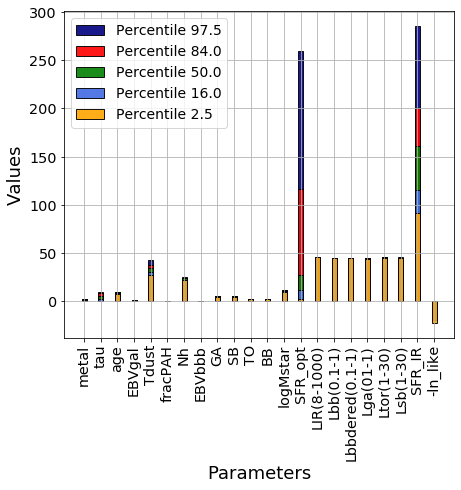

In [39]:
parameters = par278.columns

fig=plt.figure(figsize=(7,6))
plt.xlabel('Parameters', linespacing=1, fontsize = 18)
plt.ylabel('Values', linespacing=1, fontsize = 18)

#Different bars for different percentiles
plt.bar(parameters,par278.iloc[4, :],color='navy',alpha=0.9, edgecolor = 'black', width=0.3, label='Percentile 97.5')
plt.bar(parameters,par278.iloc[3, :],color='red',alpha=0.9, edgecolor = 'black', width=0.3, label='Percentile 84.0')
plt.bar(parameters,par278.iloc[2, :],color='green',alpha=0.9, edgecolor = 'black', width=0.3, label='Percentile 50.0')
plt.bar(parameters,par278.iloc[1, :],color='royalblue',alpha=0.9, edgecolor = 'black', width=0.3, label='Percentile 16.0')
plt.bar(parameters,par278.iloc[0, :],color='orange',alpha=0.9, edgecolor = 'black', width=0.3, label='Percentile 2.5')
plt.xticks(rotation=90)
plt.xticks(size = 'x-large')
plt.yticks(size = 'x-large')

plt.legend(loc=2, prop={'size': 14})
plt.grid(True)

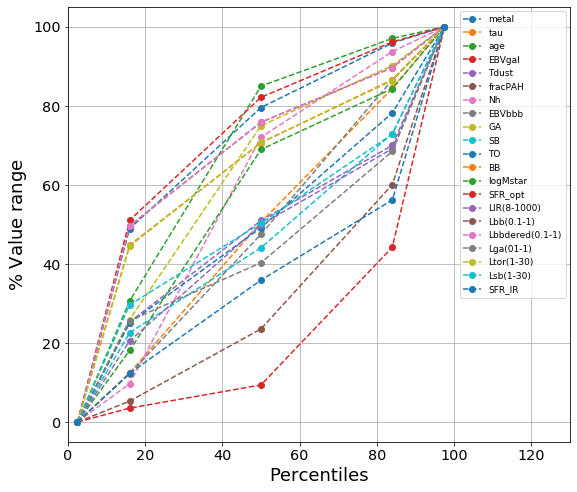

In [40]:
percentiles = [2.5, 16, 50, 84, 97.5]

fig=plt.figure(figsize=(9,8))
plt.xlabel('Percentiles', linespacing=1, fontsize = 18)
plt.ylabel(r'$\%$ Value range', linespacing=1, fontsize = 18)
for i in range(0, 21):
    # We fitted the minimum to 0 and maximum to 100 in order to see the general behaviour of the distributions
    plt.plot(percentiles, 100*(par278.iloc[:,i]-par278.iloc[:,i].min())/(par278.iloc[:,i].max()-par278.iloc[:,i].min()), marker = 'o', linestyle = '--', label = par278.columns[i])
    #/par278.iloc[:,i].max()
plt.xlim(0, 130)
plt.xticks(size = 'x-large')
plt.yticks(size = 'x-large')

plt.legend(loc=1, prop={'size': 9})
plt.grid(True)

In [41]:
SED278 = pd.read_csv("Examples/output_SEDs_278.0.txt", sep = ' ', decimal=".", skiprows = 0)
SED278 = SED278.astype(float)

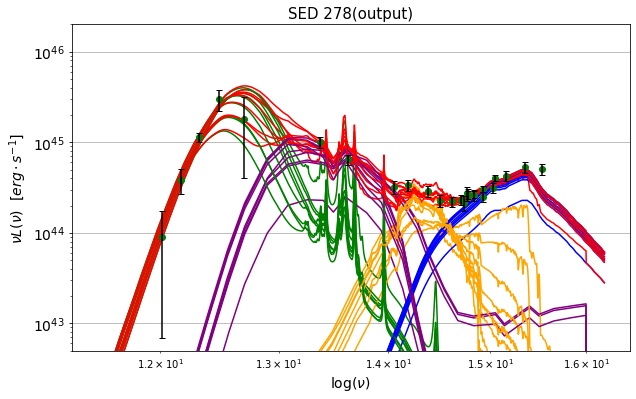

In [42]:
# Data format
# Name, redshift, Intensity [Jy], data uncertainty [Jy] and so on and so forth
SED2 = np.loadtxt("Examples/catalog_example2.txt")

#Telescopes wavelengths
l_c = [1516, 2304, 3591, 4723, 6213, 7523, 8855, 4866, 6215, 7545, 8679, 9633, 8798, 10214, 12535, 16453, 21540, 10319, 12510, 16377, 22083, 33792, 46293, 123337, 222532, 1036929, 1697692, 2493709, 3499071, 5041086]

#Observed
z = 0.731                                                   # Redshift

f_obs = [(3*10**8)/(i*10**(-10)) for i in l_c]              # Observed frequency [Hz]
data_Jy = SED2[2, 2::2]*u.Jy*1e-3                           # Intensity [Jy] 
data = data_Jy.to(u.erg/u.s/(u.cm)**2 /u.Hz).value          # Intensity [erg s⁻¹ cm⁻² Hz⁻¹]
D_L = cosmo.luminosity_distance(z).to(u.cm).value           # Relation distance-luminosity
flux =  f_obs*data*4*np.pi*(D_L)**2                         # Flux [erg s⁻¹]

# Uncertainty [erg s⁻¹]
error = f_obs*(SED2[2, 3::2]*u.Jy*1e-3).to(u.erg/u.s/(u.cm)**2 /u.Hz).value*4*np.pi*(D_L)**2 

# Rest frame frequency [Hz] 
f_rest = [i*(1+z) for i in f_obs]    


fig = plt.figure(figsize=(10, 6))
plt.ylabel(r'$\nu L(\nu)$  $[erg \cdot s^{-1}]$', fontsize = 14) 
plt.xlabel(r'log($\nu$) ', fontsize = 14) 

curvas = 9
for i in range(0, curvas):
    log_f = SED278.iloc[:, 0]        # Log frequency [Hz]
    SB = SED278.iloc[:, 1+i]         # Starburst
    BB = SED278.iloc[:, 11+i]        # Blue bump
    GA = SED278.iloc[:, 21+i]        # Galaxy
    TO = SED278.iloc[:, 31+i]        # Torus
    TOTAL = SED278.iloc[:, 41+i]     # Total
    BB_dr = SED278.iloc[:, 51+i]     # BB dereddened
    
    # OBSERVED SED
    plt.semilogy(log_f, SB, marker = '', color = 'green', linestyle = '-', label = 'SB')
    plt.semilogy(log_f, BB, marker = '', color = 'blue', linestyle = '-', label = 'BB')
    plt.semilogy(log_f, GA, marker = '', color = 'orange', linestyle = '-', label = 'GA')
    plt.semilogy(log_f, TO, marker = '', color = 'purple', linestyle = '-', label = 'TO')
    plt.semilogy(log_f, TOTAL, marker = '', color = 'red', linestyle = '-', label = 'TOTAL')
    #plt.semilogy(log_f, BB_dr, marker = '', color = 'c', linestyle = '-', label = 'BB_dr')
    
    
plt.loglog(np.log10(f_rest), flux ,color = 'green', marker = 'o', linestyle = '', label = 'Rest frame SED')
(_, caps, _) = plt.errorbar(np.log10(f_rest),  flux, yerr=  error, xerr = 0,  fmt='o', markersize=0, capsize=3, color = 'black', zorder = 10)
for cap in caps:
    cap.set_markeredgewidth(1)
plt.grid() 
plt.title('SED 278(output)', fontsize = 15)
#plt.legend(fontsize = 10, shadow = True, loc=8)
plt.ylim(5*1e42, 2*1e46)
plt.xticks(size = 14)
plt.yticks(size = 14)
plt.show()

## Run options

You can:
- To choose the number of cpus to multiprocessing
- To run the code for a specific single source
- To create independent model dictionaries for each source
- To overwrite model files

<img src="Examples/Run_options.png" width="850">

## Independent vs non-independent model dictionaries

It is important to create one model dictionary per source according to the redshift of each one. If a global model dictionary is used, the contributions of each components are differents and therefore the physical properties of the active galaxy.

<table><tr><td><img src="Examples/SED_196_i.png" width="870"></td><td><img src="Examples/SED_196_ni.png" width="840"></td></tr></table>